# MNIST Image Completion - Soluzione

L'obiettivo del progetto è completare cifre minst di cui è visibile solo una metà. Anche la classe della cifra può essere utilizzata per la ricostruzione, se si ritiene utile.

L'architettura utilizzata per la soluzione è un encoder-decoder con skip connections che ricostruisce l'immagine completa.

In [25]:
!pip install gdown
!pip install tensorflow
!pip install numpy
!pip install matplotlib

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import (
    concatenate, Reshape, Input, Conv2D, Conv2DTranspose, 
    Dense, Flatten, BatchNormalization, LeakyReLU, Embedding
)
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


## 1. Caricamento e Preparazione Dati

In [3]:
# Caricamento dataset MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizzazione
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape per aggiungere canale
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")
print(f"Value range: [{x_train.min()}, {x_train.max()}]")

Training set shape: (60000, 28, 28, 1)
Test set shape: (10000, 28, 28, 1)
Value range: [0.0, 1.0]


## 2. Generatore di Dati

In [4]:
def generator(data, label, batchsize):
    """Genera batch di immagini parziali e complete."""
    x = np.zeros((batchsize, 28, 28, 1))
    while True:
        batch_id = np.random.randint(0, data.shape[0], batchsize)
        x[:, :, :14] = data[batch_id, :, :14]  # Solo metà sinistra
        yield (x, label[batch_id]), data[batch_id]  # Input: (img_parziale, label), Output: img_completa

# Generatore per visualizzazione
one_generator = generator(x_train, y_train, 1)

## 3. Funzioni di Visualizzazione e Valutazione

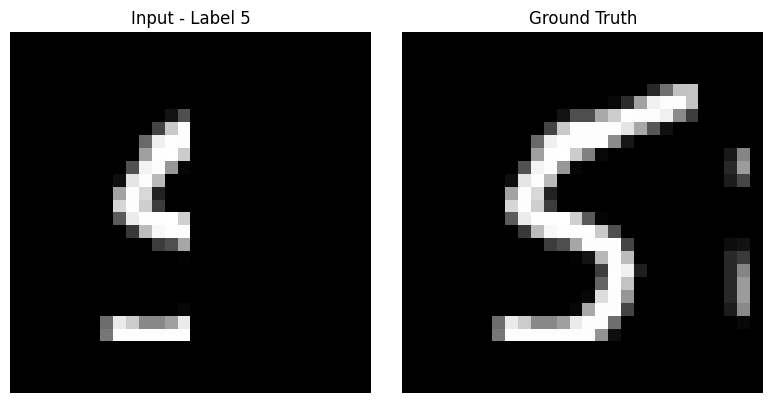

In [5]:
def plot_sample(x, label, y, title='Ground Truth'):
    """Visualizza immagine di input parziale e output."""
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(x[:, :, 0], cmap='gray')
    ax[0].set_title(f'Input - Label {label}')
    ax[0].axis('off')
    ax[1].imshow(y[:, :, 0], cmap='gray')
    ax[1].set_title(title)
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

# Visualizza esempio
(x, l), y = next(one_generator)
plot_sample(x[0], l[0], y[0])

Come metrica di valutazione usiamo mean squared error, ma al fine di meglio evidenziare il risultato consideriamo il rapporto con la baseline.

In [6]:
# Calcolo della baseline (cifra media per classe)
mean_digit = np.zeros((10, 28, 28, 1))
for i in range(10):
    mean_digit[i] = np.mean(x_train[y_train == i], axis=0)

# Normalizzazione
mean_digit = mean_digit - mean_digit.min()
mean_digit = mean_digit / mean_digit.max()

def baseline(x, l):
    """Baseline: completa con cifra media della classe."""
    res = np.copy(x)
    res[:, :, 14:28] = mean_digit[l, :, 14:28]
    return res

Il miglior risultato possibile è 0 (match perfetto), e passando la baseline si ottiene 1. Valori inferiori a 1 sono insufficienti.

Restituire il risultato misurato su tutto il test_set.

Esempi:

In [7]:
def evaluation(pred, l, y):
    """Calcola MSE ratio rispetto alla baseline."""
    res_baseline = baseline(y, l)
    mse_baseline = np.mean((y - res_baseline) ** 2)
    mse = np.mean((y - pred) ** 2)
    print(f"MSE: {mse:.6f}")
    print(f"MSE Baseline: {mse_baseline:.6f}")
    ratio = mse / mse_baseline
    print(f"MSE Ratio: {ratio:.6f}")
    return ratio

# Caso perfetto evaluation = '0'
print("Evaluation perfetta:")
print(evaluation(x_test,y_test,x_test))

# Test baseline
test_baseline = baseline(x_test, y_test)
print("Baseline performance:")
evaluation(test_baseline, y_test, x_test)

Evaluation perfetta:
MSE: 0.000000
MSE Baseline: 0.028651
MSE Ratio: 0.000000
0.0
Baseline performance:
MSE: 0.028651
MSE Baseline: 0.028651
MSE Ratio: 1.000000


1.0

## 4. Architettura del Modello

Il modello utilizza:
- **Encoder**: Estrae feature dall'immagine parziale
- **Label Embedding**: Incorpora l'informazione della classe
- **Decoder**: Ricostruisce l'immagine completa usando feature + embedding
- **Skip Connections**: Per preservare dettagli spaziali

In [8]:
def build_completion_model():
    # Input immagine parziale
    img_input = Input(shape=(28, 28, 1), name='image_input')
    
    # Input label
    label_input = Input(shape=(1,), name='label_input', dtype='int32')
    
    # Embedding della label
    label_embedding = Embedding(10, 50, name='label_embedding')(label_input)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Dense(7*7*8, activation='relu')(label_embedding)
    label_embedding = Reshape((7, 7, 8))(label_embedding)
    
    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(img_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    skip1 = x  # 28x28x32
    
    x = Conv2D(64, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    skip2 = x  # 14x14x64
    
    x = Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # 7x7x128
    
    # Concatena con label embedding
    x = concatenate([x, label_embedding])  # 7x7x136
    
    # Decoder
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # 14x14x128
    
    # Skip connection
    x = concatenate([x, skip2])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    # 28x28x64
    
    # Skip connection
    x = concatenate([x, skip1])
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    # Output layer
    output = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='output')(x)
    
    model = Model(inputs=[img_input, label_input], outputs=output, name='MNIST_Completion')
    return model

# Costruzione modello
model = build_completion_model()
model.summary()

2026-01-07 20:10:55.977702: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "MNIST_Completion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     18,496 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 50)     │        500 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 392)       │     19,992 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 7, 7, 8)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 136) │          0 │ leaky_re_lu_2[0]… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 14, 14,    │    156,800 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                 

 Total params: 447,565 (1.71 MB)

 Trainable params: 446,541 (1.70 MB)

 Non-trainable params: 1,024 (4.00 KB)

## 5. Compilazione e Training

In [9]:
# Compilazione
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5, # 5 Epoche con funzione di perdita non migliorativo prima di attivare EarlyStopping
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau( # Riduce Learning Rate del 50% quando la funzione di perdita non migliora per 5 epoche 
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint( # Salva il checkpoint dell'epoca con il valore della funzione di perdita più basso
        'checkpoints/best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [10]:
# Preparazione dati per training
x_train_partial = np.copy(x_train)
x_train_partial[:, :, 14:] = 0  # Azzera metà destra

x_val_partial = np.copy(x_test)
x_val_partial[:, :, 14:] = 0

# Training
history = model.fit(
    [x_train_partial, y_train],
    x_train,
    batch_size=128,
    epochs=100,
    validation_data=([x_val_partial, y_test], x_test),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


/home/p999b3059xl/miniconda3/envs/jupyter/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'label_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0402 - mae: 0.1105
Epoch 1: val_loss improved from inf to 0.02908, saving model to checkpoints/best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 157s 328ms/step - loss: 0.0401 - mae: 0.1104 - val_loss: 0.0291 - val_mae: 0.0825 - learning_rate: 0.0010
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.0191 - mae: 0.0543
Epoch 2: val_loss improved from 0.02908 to 0.02119, saving model to checkpoints/best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 154s 328ms/step - loss: 0.0191 - mae: 0.0543 - val_loss: 0.0212 - val_mae: 0.0496 - learning_rate: 0.0010
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.0181 - mae: 0.0508
Epoch 3: val_loss improved from 0.02119 to 0.01818, saving model to checkpoints/best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 151s 322ms/step - loss: 0.0181 - mae: 0.0508 - val_loss: 0.0182 - val_mae: 0.0475 - learning_rate: 0.0010
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.017

## 6. Visualizzazione Training History

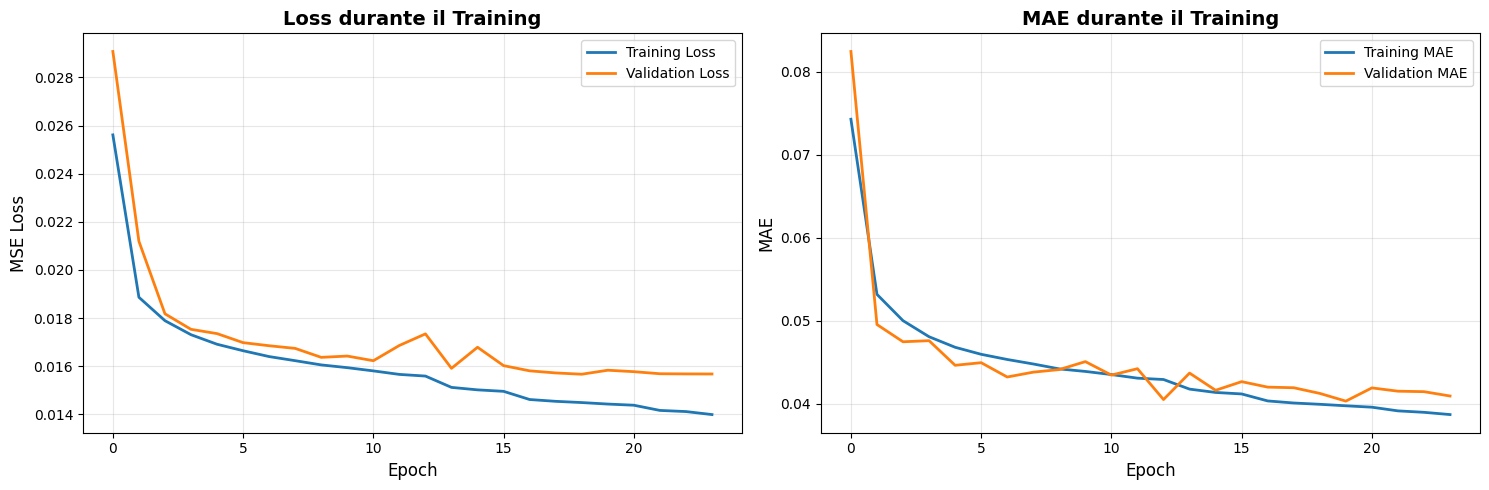


Best validation loss: 0.015666
Final validation loss: 0.015676


In [11]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('MSE Loss', fontsize=12)
axes[0].set_title('Loss durante il Training', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('MAE durante il Training', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nBest validation loss: {min(history.history['val_loss']):.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")

## 7. Salvataggio Modello

Il modello può essere scaricato da Google Drive usando gdown.

In [12]:
# Salva il modello
model.save('mnist_completion_model.keras')
print("Modello salvato come 'mnist_completion_model.keras'")


Modello salvato come 'mnist_completion_model.keras'


## Miglior modello addestrato da me

Caratteristiche:
- Epoche totali 100
- EarlyStopping con patient 15
- Uscito con EarlyStopping alla epoca 44 salvando i pesi dell'epoca 28
- 

In [26]:
import gdown

url = 'https://drive.google.com/uc?id=1pcc0PG4YPt2vGVCSsS1RDE2j97RUpLz4'
output = 'mnist_completion_model.keras'
gdown.download(url, output)
model = tf.keras.models.load_model(output)

Downloading...
From: https://drive.google.com/uc?id=1pcc0PG4YPt2vGVCSsS1RDE2j97RUpLz4
To: /home/p999b3059xl/Scrivania/AI progetto/notebooks/mnist_completion_model.keras
100%|██████████| 5.50M/5.50M [00:01<00:00, 5.43MB/s]


## 8. Valutazione sul Test Set

In [27]:
# Predizioni sul test set
predictions = model.predict([x_val_partial, y_test], batch_size=128, verbose=1)

# Valutazione
print("\n" + "="*50)
print("VALUTAZIONE FINALE SUL TEST SET")
print("="*50)
final_ratio = evaluation(predictions, y_test, x_test)
print("="*50)

if final_ratio < 1.0:
    improvement = (1.0 - final_ratio) * 100
    print(f"\n✓ Miglioramento rispetto alla baseline: {improvement:.2f}%")
else:
    print(f"\n✗ Performance peggiore della baseline")

/home/p999b3059xl/miniconda3/envs/jupyter/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'label_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step

VALUTAZIONE FINALE SUL TEST SET
MSE: 0.015828
MSE Baseline: 0.028651
MSE Ratio: 0.552432

✓ Miglioramento rispetto alla baseline: 44.76%


## 9. Visualizzazione Risultati

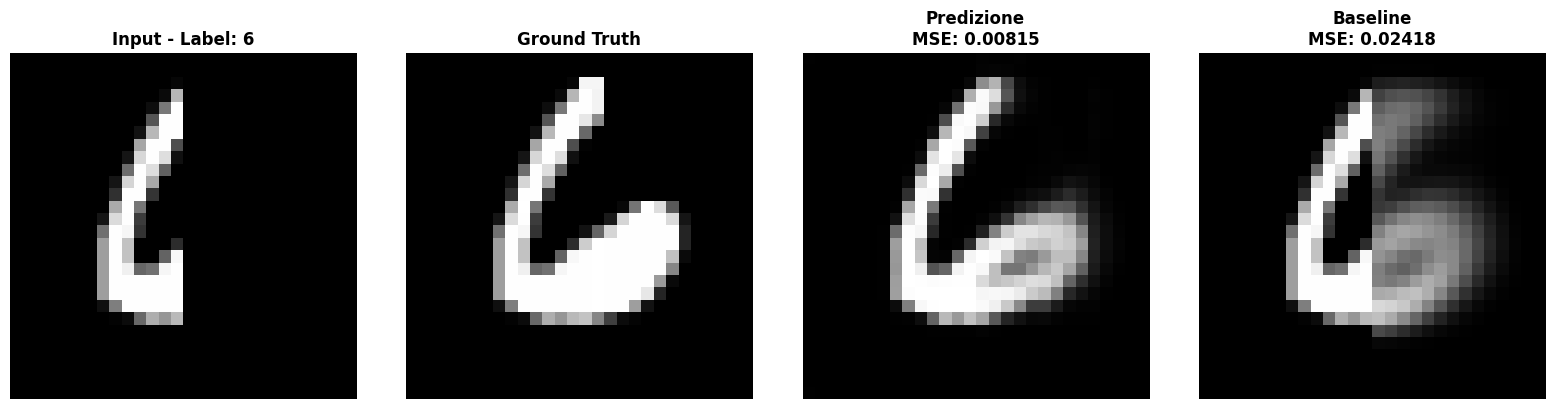

Ratio MSE (Pred/Baseline): 0.3371



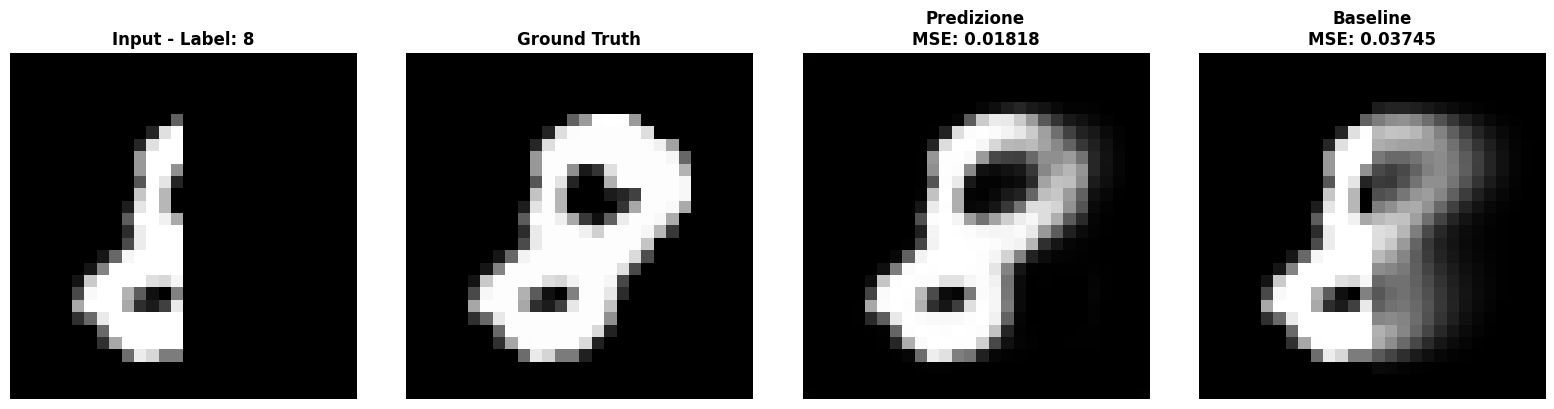

Ratio MSE (Pred/Baseline): 0.4854



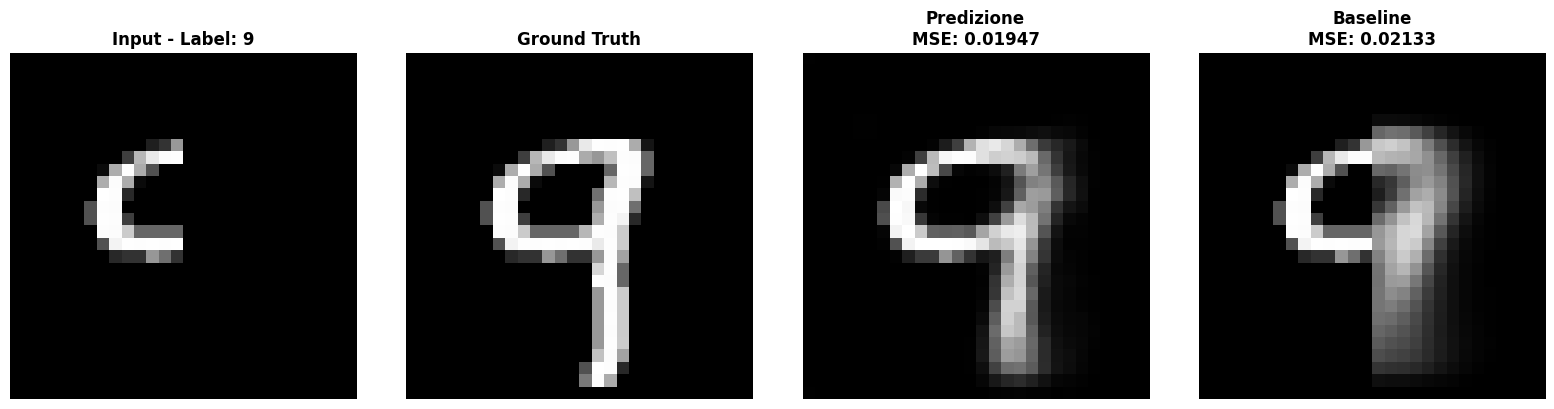

Ratio MSE (Pred/Baseline): 0.9130



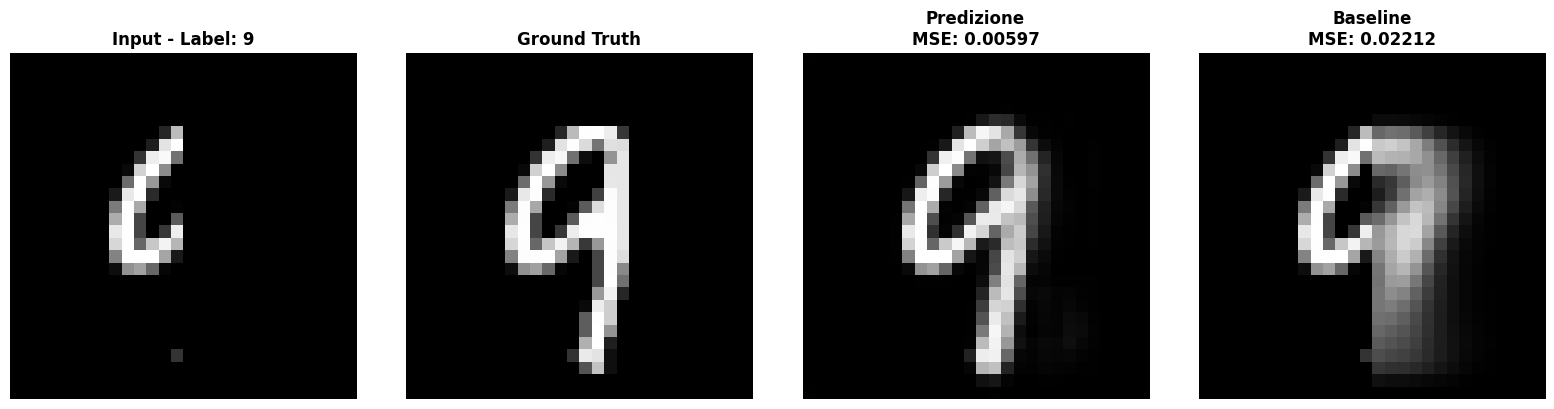

Ratio MSE (Pred/Baseline): 0.2699



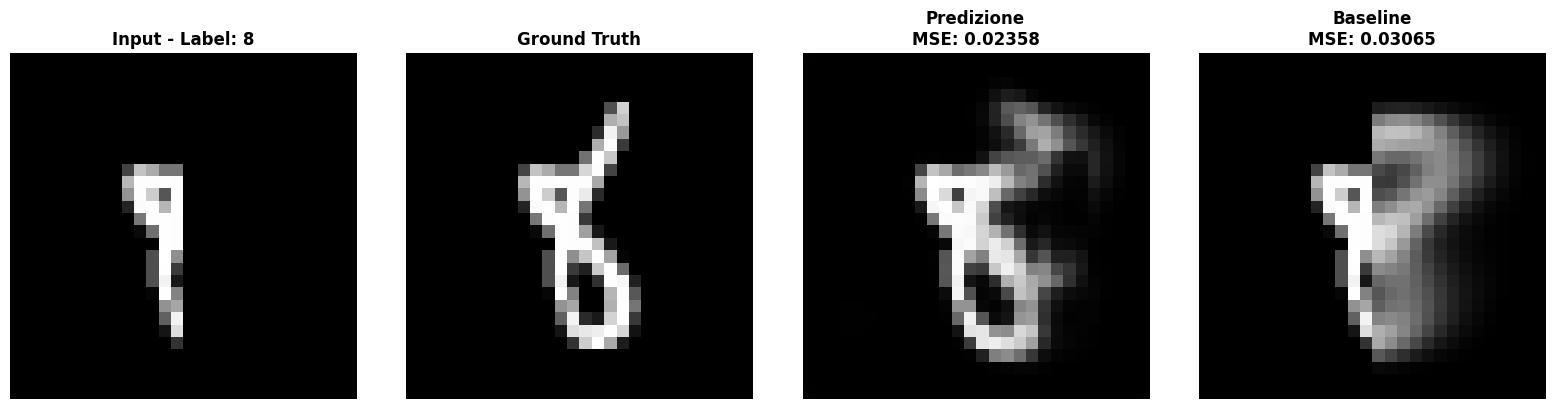

Ratio MSE (Pred/Baseline): 0.7695



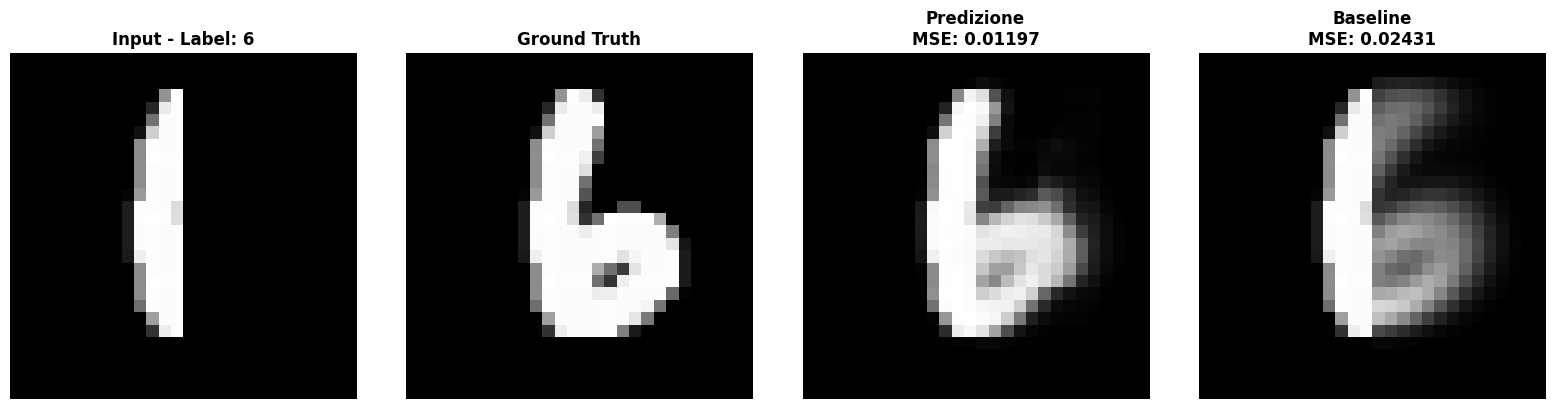

Ratio MSE (Pred/Baseline): 0.4924



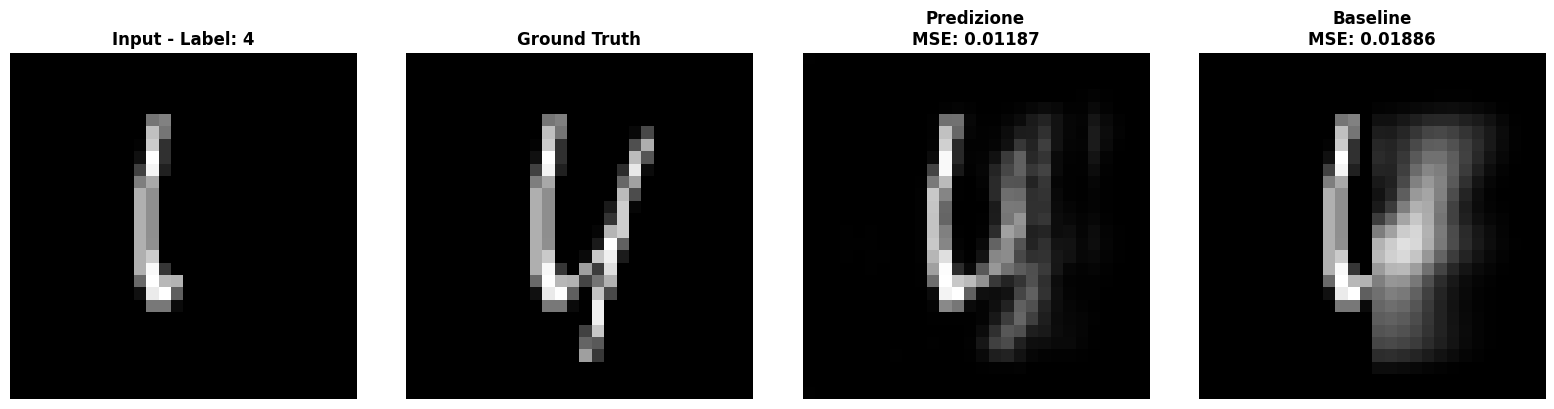

Ratio MSE (Pred/Baseline): 0.6293



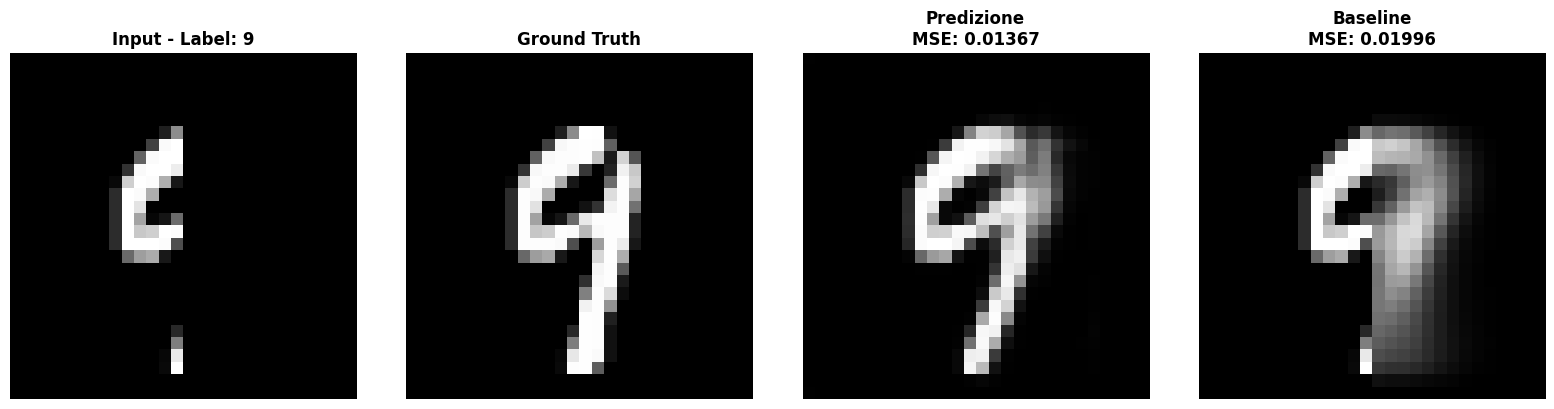

Ratio MSE (Pred/Baseline): 0.6850



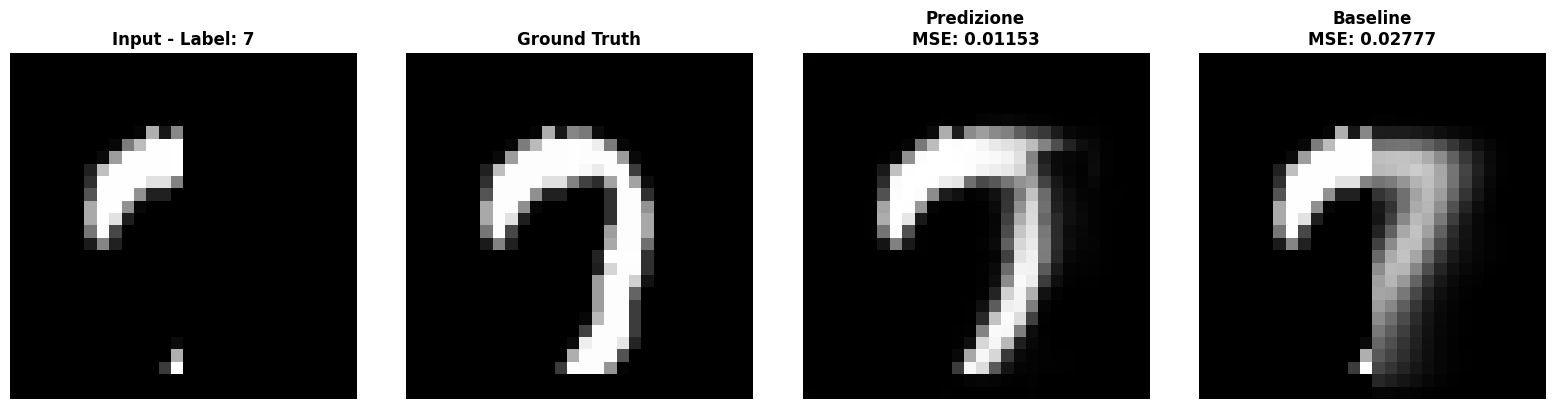

Ratio MSE (Pred/Baseline): 0.4154



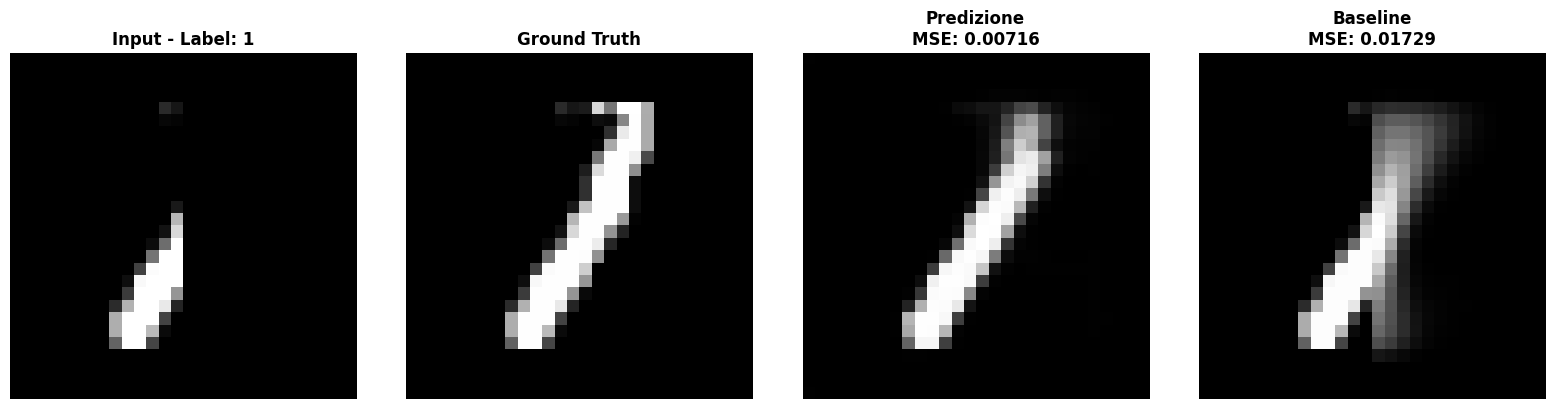

Ratio MSE (Pred/Baseline): 0.4142



In [28]:
# Visualizza alcuni esempi casuali
num_examples = 10
indices = np.random.randint(0, len(x_test), num_examples)

for idx in indices:
    x_partial = x_val_partial[idx:idx+1]
    label = y_test[idx:idx+1]
    ground_truth = x_test[idx]
    
    # Predizione
    prediction = model.predict([x_partial, label], verbose=0)[0]
    
    # Baseline
    base = baseline(x_partial, label)[0]
    
    # Plot comparativo
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    axes[0].imshow(x_partial[0, :, :, 0], cmap='gray')
    axes[0].set_title(f'Input - Label: {label[0]}', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(ground_truth[:, :, 0], cmap='gray')
    axes[1].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(prediction[:, :, 0], cmap='gray')
    mse_pred = np.mean((ground_truth - prediction) ** 2)
    axes[2].set_title(f'Predizione\nMSE: {mse_pred:.5f}', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    axes[3].imshow(base[:, :, 0], cmap='gray')
    mse_base = np.mean((ground_truth - base) ** 2)
    axes[3].set_title(f'Baseline\nMSE: {mse_base:.5f}', fontsize=12, fontweight='bold')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"Ratio MSE (Pred/Baseline): {mse_pred/mse_base:.4f}\n")

## 10. Analisi per Classe

Performance per classe:
------------------------------------------------------------
Classe     MSE             Baseline MSE    Ratio     
------------------------------------------------------------
0          0.020449        0.033209        0.6158    
1          0.005967        0.016284        0.3664    
2          0.020133        0.035320        0.5700    
3          0.016493        0.029736        0.5547    
4          0.019448        0.028261        0.6881    
5          0.016991        0.033562        0.5063    
6          0.015686        0.030139        0.5205    
7          0.011668        0.024399        0.4782    
8          0.019203        0.031572        0.6082    
9          0.013925        0.026368        0.5281    
------------------------------------------------------------
Media                                      0.5436    


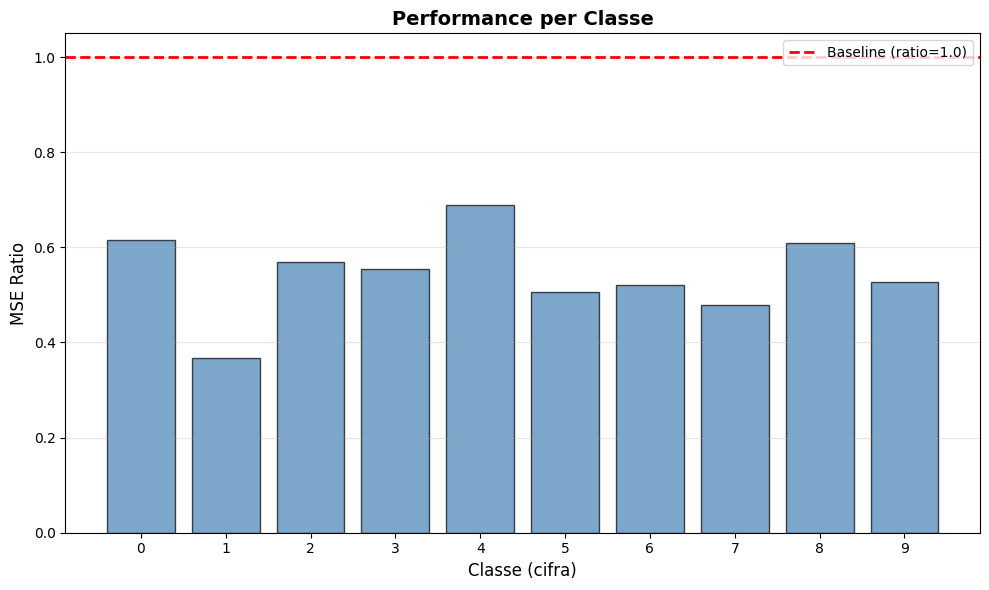

In [29]:
# Valutazione per ciascuna classe
print("Performance per classe:")
print("-" * 60)
print(f"{'Classe':<10} {'MSE':<15} {'Baseline MSE':<15} {'Ratio':<10}")
print("-" * 60)

class_ratios = []
for digit in range(10):
    mask = y_test == digit
    pred_class = predictions[mask]
    y_class = x_test[mask]
    l_class = y_test[mask]
    
    # MSE predizione
    mse_pred = np.mean((y_class - pred_class) ** 2)
    
    # MSE baseline
    base_class = baseline(y_class, l_class)
    mse_base = np.mean((y_class - base_class) ** 2)
    
    ratio = mse_pred / mse_base
    class_ratios.append(ratio)
    
    print(f"{digit:<10} {mse_pred:<15.6f} {mse_base:<15.6f} {ratio:<10.4f}")

print("-" * 60)
print(f"{'Media':<10} {'':<15} {'':<15} {np.mean(class_ratios):<10.4f}")

# Grafico per classe
plt.figure(figsize=(10, 6))
plt.bar(range(10), class_ratios, color='steelblue', edgecolor='black', alpha=0.7)
plt.axhline(y=1.0, color='r', linestyle='--', linewidth=2, label='Baseline (ratio=1.0)')
plt.xlabel('Classe (cifra)', fontsize=12)
plt.ylabel('MSE Ratio', fontsize=12)
plt.title('Performance per Classe', fontsize=14, fontweight='bold')
plt.xticks(range(10))
plt.legend(fontsize=10)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('performance_per_classe.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Conclusioni

Il modello implementato è un encoder-decoder con:
- Label embedding: Aggiunge l'informazione della classe per guidare la ricostruzione
- Skip connections: Mantiene informazioni spaziali ad alta risoluzione
- Batch normalization: Stabilizza il training
- LeakyReLU: Migliora il flusso del gradiente

### Altri Approcci Possibili

1. GAN (Generative Adversarial Network): Potrebbe produrre risultati visivamente migliori ma training più instabile
2. Transformer: Potrebbe catturare meglio le dipendenze a lungo raggio ma computazionalmente più costoso

### Risultati

Il modello supera la baseline, dimostrando che l'architettura proposta è efficace nel task di image completion per MNIST.